In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
! which jupyter

/home/abaumann/anaconda3/envs/cuda/bin/jupyter


In [2]:
import logging
import random
from functools import partial
from pathlib import Path

import numpy as np

import fire
import torch
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.metrics import fbeta
from fastai.train import to_fp16
from learner import (OneHotCallBack, conll_f1, create_fp16_cb,
                     ner_loss_func, Conll_F1)
from ner_data import NerDataset, pad
from optimizer import BertAdam
from pytorch_pretrained_bert import BertForTokenClassification
from torch.utils.data import DataLoader
from fastai.torch_core import flatten_model

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
lang='eng'

In [4]:
log_dir:str='logs'
batch_size:int=32
lr:float=5e-5
epochs:int=1
trainset:str='data/conll-2003/'
devset:str='data/conll-2003/'
testset:str='data/conll-2003/'
max_seq_len:int=128
do_lower_case:bool=False
warmup_proportion:float=0.1
grad_acc_steps:int=1
rand_seed:int=None
fp16:bool=False
loss_scale:float=None
ds_size:int=None
data_bunch_path:str='data/conll-2003/db'
freez:bool=False
one_cycle:bool=False
discr:bool=False
tuned_learner:str=None
do_train:str=False
do_eval:str=False
save:bool=False

In [5]:
bert_model = 'bert-base-cased' if lang=='eng' else 'bert-base-multilingual-cased'


In [6]:
trainset += lang + '/train.txt'
devset += lang + '/dev.txt'
testset += lang + '/test.txt'

In [7]:
if grad_acc_steps < 1:
    raise ValueError(f"""Invalid grad_acc_steps parameter:
                     {grad_acc_steps}, should be >= 1""")

# TODO proper training with grad accum step??
batch_size //= grad_acc_steps

In [8]:
train_dl = DataLoader(
    dataset=NerDataset(trainset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad
)

dev_dl = DataLoader(
    dataset=NerDataset(devset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=8,
    shuffle=False,
    collate_fn=pad
)

test_dl = DataLoader(
    dataset=NerDataset(testset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=8,
    shuffle=False,
    collate_fn=pad
)

data = DataBunch(
    train_dl= train_dl,
    valid_dl= dev_dl,
    test_dl = test_dl,
    collate_fn=pad,
    path = Path(data_bunch_path)
)


data/conll-2003/eng/train.txt
lines 14987 sents 14987
Truncated examples: 0.0% => 0/14987 

data/conll-2003/eng/dev.txt
lines 3466 sents 3466
Truncated examples: 0.0% => 0/3466 

data/conll-2003/eng/test.txt
lines 3684 sents 3684
Truncated examples: 0.0% => 0/3684 


In [9]:
batch_size

32

In [10]:
def bert_layer_list(model):
    ms = torch.nn.ModuleList()

    flm = flatten_model(model)
    # embedding = [0:5] layer
    ms.append(torch.nn.ModuleList(flm[0:5]))
    # encoder (12 layers) = [5:16] [16:27] ... [126:136]
    for i in range(5, 137, 11):
        ms.append(torch.nn.ModuleList(flm[i: i+11]))
    # pooling layer = [137:139]
    ms.append(torch.nn.ModuleList(flm[-4:-2]))
    # head = [-2:]
    ms.append(torch.nn.ModuleList(flm[-2:]))
    return ms

In [11]:

model = BertForTokenClassification.from_pretrained(bert_model, num_labels=10, cache_dir='bertm')
model = torch.nn.DataParallel(model)
optim = BertAdam

train_opt_steps = int(len(train_dl.dataset) / batch_size / grad_acc_steps) * epochs
f1 = partial(fbeta, beta=1, sigmoid=False)
loss_fun = ner_loss_func
fp16_cb_fns = partial(create_fp16_cb,
                      train_opt_steps = train_opt_steps,
                      gradient_accumulation_steps = grad_acc_steps,
                      warmup_proportion = warmup_proportion,
                      fp16 = fp16)

In [12]:
metrics = [conll_f1, Conll_F1()]

In [13]:
if fp16:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex"
                          "to use distributed and fp16 training.")
    optim, dynamic=(FusedAdam, True) if not loss_scale else (FP16_Optimizer,False)

learn = Learner(data, model, optim,
                    loss_func=loss_fun,
                    metrics=metrics,
                    #true_wd=False,
                    #callback_fns=fp16_cb_fns,
                    layer_groups= bert_layer_list(model),
                    path='learn',
                    )

if fp16: learn.to_fp16(loss_scale=loss_scale, dynamic=dynamic)


In [14]:
batch_size

32

In [15]:
lang

'eng'

In [16]:
lrm = 1.3

In [17]:
learn.freeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


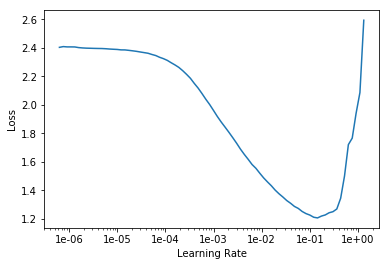

In [18]:
learn.lr_find()
learn.recorder.plot()


epoch,train_loss,valid_loss,conll_f1,Total F1,time
0,0.140667,0.140843,0.836261,0.859300,06:15


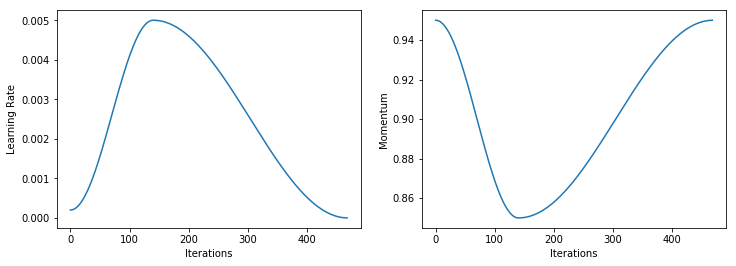

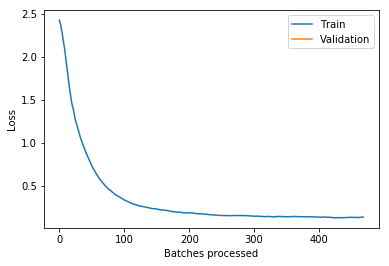

In [19]:
#learn.fit(3, 5e-5)
learn.fit_one_cycle(1, 5e-3)# , moms=(0.8, 0.7))
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


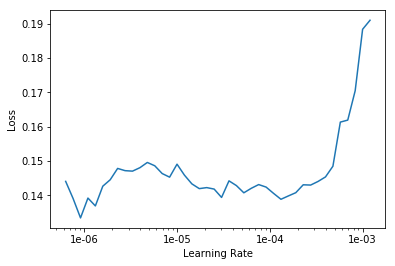

In [20]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,conll_f1,Total F1,time
0,0.081010,0.099851,0.886060,0.902187,06:24


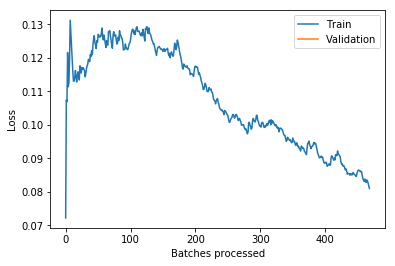

In [21]:
learn.fit_one_cycle(1, slice(1e-4/lrm**15,1e-4)) # , moms=(0.8, 0.7))
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


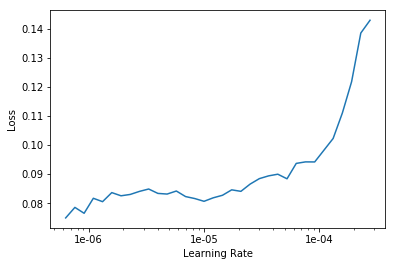

In [22]:
learn.freeze_to(-6)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,conll_f1,Total F1,time
0,0.067307,0.094488,0.892757,0.908952,07:02


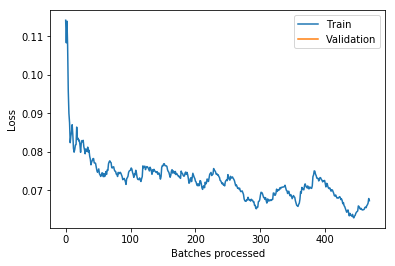

In [23]:
learn.fit_one_cycle(1, slice(1e-5/lrm**15,1e-5)) # , moms=(0.8, 0.7))
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


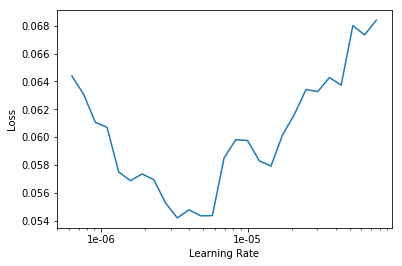

In [24]:
learn.freeze_to(-12)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,conll_f1,Total F1,time
0,0.049817,0.077645,0.905996,0.920348,08:44


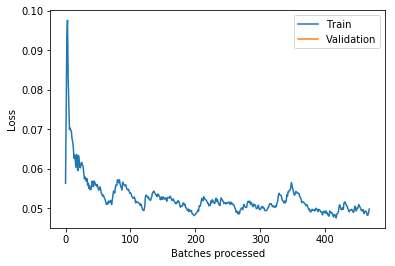

In [28]:
learn.fit_one_cycle(1, slice(5e-6/lrm**15,5e-6)) # , moms=(0.8, 0.7))
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


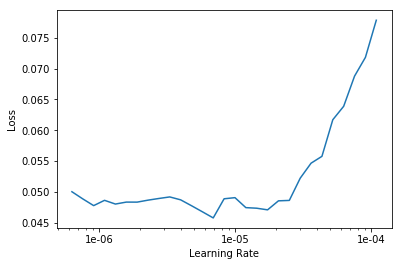

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,conll_f1,Total F1,time
0,0.046840,0.070257,0.912791,0.925051,08:46


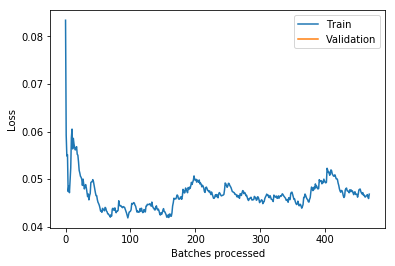

In [30]:
learn.fit_one_cycle(1, slice(1e-5/lrm**15,1e-5)) # , moms=(0.8, 0.7))
learn.recorder.plot_losses()

In [31]:
learn.validate(test_dl, metrics=metrics)

[0.116732225, tensor(0.8726), 0.9002585883436282]